<a href="https://colab.research.google.com/github/pAppr69/Win-Factor_yashjeet/blob/main/submissions_Yashjeet/basic_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [85]:
url = 'https://media.githubusercontent.com/media/pAppr69/Win-Factor_yashjeet/refs/heads/main/mw_pw_profiles.csv'
df = pd.read_csv(url)

In [86]:
def get_info(df):
  info_dict = {
      "Column_Name": df.columns,
      "Data_Type": df.dtypes,
      "NaN_Percentage": (df.isna().sum() / len(df) * 100).round(2)
  }
  return pd.DataFrame(info_dict)
get_info(df)

,Column_Name,Data_Type,NaN_Percentage
player_id,player_id,object,0.00
match_id,match_id,object,0.00
gender,gender,object,0.00
balls_per_over,balls_per_over,int64,0.00
start_date,start_date,object,0.00
series_name,series_name,object,0.47
match_type,match_type,object,0.00
name_x,name_x,object,0.00
runs_scored,runs_scored,int64,0.00
player_out,player_out,int64,0.00


In [87]:
df.match_type.value_counts()

,count
match_type,
T20,252665
ODI,65192
MDM,39693
ODM,33115
Test,19007
IT20,7040


In [88]:
df.match_id.unique().shape

(18896,)

In [89]:
df_T20 = df[df['match_type'] == 'T20']

In [90]:
df = df[['player_id','match_id','start_date','gender','order_seen', 'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done', 'balls_bowled',
              'runs_conceded', 'wickets_taken', 'maidens', 'dot_balls_as_bowler', 'dot_balls_as_batsman', 'match_type',
              'runs_scored', 'balls_faced', 'fours_scored', 'sixes_scored','fantasy_score_bowling', 'fantasy_score_batting', 'fantasy_score_total']]

Inserting new columns: STRIKE RATE | Economy   

In [91]:
df = df.dropna()

## Boundaries
df['boundaries'] = df['sixes_scored']+df['fours_scored']

## fielding
df['fielding'] = df['run_out_direct'] + df['run_out_throw'] + df['stumpings_done'] + df['catches_taken']

## dots as bowler -- a little bonus for a maiden over
df['dots'] = df['dot_balls_as_bowler'] + df['maidens']*6.9

## dot balls %percentage
df['dot_balls_as_batsman_percentage'] = (df['dot_balls_as_batsman'] / df['balls_faced'])

##
df['batting_aggression'] = np.where(df.balls_faced != 0, (((2*df['sixes_scored'] + df['fours_scored']) / df['balls_faced'])), 0)

df = df.drop(['sixes_scored', 'fours_scored', 'run_out_direct', 'run_out_throw', 'stumpings_done', 'catches_taken', 'dot_balls_as_bowler', 'maidens'], axis=1)


df['strike_rate'] = np.where(df.balls_faced != 0, ((df['runs_scored'] / df['balls_faced']) * 100), 0)

df['economy'] = np.where(df.balls_bowled != 0, ((df['runs_conceded'] / df['balls_bowled']) * 100), 0)
## players with 0 bowls bowled have an ideal economy, can worsen our model
## distinction between bowlers and batsmen is important to create these
# 🥀🥀🥀 gotta do something else

In [92]:
def identify_player_role(df_player):

    total_matches = len(df_player)
    # percentage of matches with non-zero bowls bowled
    bowling_matches = (df_player['balls_bowled'] > 0).sum()
    bowling_percentage = (bowling_matches / total_matches) if total_matches > 0 else 0

    # percentage of matches with non-zero balls faced
    batting_matches = (df_player['balls_faced'] > 0).sum()
    batting_percentage = (batting_matches / total_matches) if total_matches > 0 else 0

    #average order seen
    average_order_seen = df_player['order_seen'].mean()

    if bowling_percentage >= 0.70:
        if batting_percentage >= 0.60 and average_order_seen > 6.5: # Using 6.5 as the threshold for order seen
            return 'All-Rounder'
        else:
            return 'Bowler'
    else:
        return 'Batsman'


player_roles = df.groupby('player_id').apply(identify_player_role).reset_index(name='player_role')

df = df.merge(player_roles, on='player_id', how='right')
df.drop('order_seen', axis=1, inplace=True)
print("\nDistribution of Player Roles:")
print(player_roles['player_role'].value_counts())



Distribution of Player Roles:
player_role
Batsman        6087
Bowler         5449
All-Rounder     235
Name: count, dtype: int64


In [93]:
df.player_id.unique().shape

(11771,)

In [94]:
df['start_date'] = pd.to_datetime(df['start_date'])
df = df.sort_values(by='start_date')
df.reset_index(inplace=True)

In [95]:
df.drop(columns=['index'], inplace=True)

In [ ]:
# leave for now, will do within boosting models
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['player_id','gender', 'series_name', 'player_team', 'opposition_team']

label_encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

## Using Moving averages to make my features based on form of the player

In [96]:
df.columns

Index(['player_id', 'match_id', 'start_date', 'gender', 'balls_bowled',
       'runs_conceded', 'wickets_taken', 'dot_balls_as_batsman', 'match_type',
       'runs_scored', 'balls_faced', 'fantasy_score_bowling',
       'fantasy_score_batting', 'fantasy_score_total', 'boundaries',
       'fielding', 'dots', 'dot_balls_as_batsman_percentage',
       'batting_aggression', 'strike_rate', 'economy', 'player_role'],
      dtype='object')

In [97]:
# SMA
def calc_sma(df, window, cols=['boundaries', 'fielding', 'dots', 'strike_rate', 'economy']):
  df_sma = df.copy()
  for col in cols:
    if col in df_sma.columns:
      df_sma[f'{col}_sma'] = df_sma.groupby('player_id')[col].transform(lambda x: x.rolling(window=window).mean())
      df_sma.drop(col,axis=1, inplace=True)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")
  return df_sma

In [98]:
# WMA
def calc_wma(df, span, w=(1 + 5**0.5) / 2, cols=['boundaries', 'fielding', 'dots', 'strike_rate', 'economy',
                                                 'runs_scored','runs_conceded','wickets_taken']):
    ## using the weights as exponents of the golden ratio
    df_wma = df.copy()
    weights = np.array([w**(span - i - 1) for i in range(span)])
    weights /= weights.sum() # Normalize weights

    for col in cols:
        if col in df_wma.columns:
            df_wma[f'{col}_wma'] = df_wma.groupby('player_id')[col].transform(
                lambda x: x.rolling(window=span).apply(lambda y: np.dot(y, weights), raw=True)
            )
            df_wma.drop(col, axis=1, inplace=True)
        else:
          print(f"{col} missing in df")
    return df_wma

In [99]:
df_wma = calc_wma(df,5)

In [108]:
# The ARITRA feature, finally 🗿

weights = [0.4,0.3,0.2,0.1]

df_wma['rolling_fantasy_batting'] = df_wma.groupby('player_id')['fantasy_score_batting'].transform(
                lambda x: x.shift(1).rolling(window=4).apply(lambda y: np.dot(y, weights), raw=True)
            )
df_wma['rolling_fantasy_bowling'] = df_wma.groupby('player_id')['fantasy_score_bowling'].transform(
                lambda x: x.shift(1).rolling(window=4).apply(lambda y: np.dot(y, weights), raw=True)
            )
df_wma['rolling_fantasy_total'] = df_wma.groupby('player_id')['fantasy_score_total'].transform(
                lambda x: x.shift(1).rolling(window=4).apply(lambda y: np.dot(y, weights), raw=True)
            )

In [111]:
df_wma.columns.shape

(25,)

## Random Forest

In [112]:
def train_random_forest(X,y):
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.compose import ColumnTransformer
  from sklearn.pipeline import Pipeline
  from sklearn.model_selection import train_test_split, cross_val_score
  from sklearn.metrics import mean_squared_error, r2_score
  from sklearn.preprocessing import StandardScaler
  import numpy as np


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  # Drop non-numeric columns
  numeric_cols = X_train.select_dtypes(include=np.number).columns
  X_train = X_train[numeric_cols]
  X_test = X_test[numeric_cols]


  model = RandomForestRegressor(n_estimators=50, random_state=1)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)


  ## evaluating the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print("-- Random Forest Evaluation Scores--")

  # scores = cross_val_score(model, X, y, cv=5, scoring = 'r2')
  print(f"Mean Squared Error: {mse:.4f}")
  print(f"R² Score: {r2:.4f}")

  importances = model.feature_importances_
  feature_names = X_train.columns

  print('\n\n- Feature Wise Importance -')
  for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

  return model

In [113]:
def train_xgboost_with_gridsearch(X,y):

    from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.metrics import mean_squared_error, r2_score


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

    #base model
    model = XGBRegressor(random_state=2, n_jobs=-1)
    param_grid = {
        'n_estimators': [50],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2,4,8],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1.0]
    }


    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    importances = best_model.feature_importances_
    feature_names = X_train.columns

    print("-- XGBoost Scores --")
    print()
    print("Best Parameters:", grid_search.best_params_)
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")

    print('- Feature Wise Importance -')
    for feature, importance in zip(feature_names, importances):
        print(f"{feature}: {importance:.4f}")
    return best_model

### For Batsmen

Dropping economy because the column was cracked, remember?

In [114]:
df_bat = df_wma[df_wma['player_role'] == 'Batsman']

In [115]:
X = df_bat.drop(columns=['fantasy_score_batting','match_type','fantasy_score_bowling','fantasy_score_total','match_id','player_role','balls_faced','dot_balls_as_batsman'])
y = df_bat['fantasy_score_total']

In [117]:
X.columns

Index(['player_id', 'start_date', 'gender', 'balls_bowled',
       'dot_balls_as_batsman_percentage', 'batting_aggression',
       'boundaries_wma', 'fielding_wma', 'dots_wma', 'strike_rate_wma',
       'economy_wma', 'runs_scored_wma', 'runs_conceded_wma',
       'wickets_taken_wma', 'rolling_fantasy_batting',
       'rolling_fantasy_bowling', 'rolling_fantasy_total'],
      dtype='object')

In [122]:
model_1 = train_random_forest(X.drop('start_date', axis=1),y)

-- Random Forest Evaluation Scores--
Mean Squared Error: 547.0038
R² Score: 0.6952


- Feature Wise Importance -
balls_bowled: 0.0508
dot_balls_as_batsman_percentage: 0.0870
batting_aggression: 0.3072
boundaries_wma: 0.0525
fielding_wma: 0.0359
dots_wma: 0.0081
strike_rate_wma: 0.0449
economy_wma: 0.0089
runs_scored_wma: 0.1787
runs_conceded_wma: 0.0077
wickets_taken_wma: 0.0103
rolling_fantasy_batting: 0.1632
rolling_fantasy_bowling: 0.0193
rolling_fantasy_total: 0.0256


In [125]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.1 MB/s eta 0:00:00


In [126]:
def train_xgboost_with_gridsearch(X, y):
    from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV, train_test_split, KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from category_encoders import TargetEncoder
    import pandas as pd
    import numpy as np

    X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.25, random_state=2)

    # Target Encoding with Cross-Validation
    categorical_cols = ['player_id', 'gender']
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    for col in categorical_cols:
        # Prepare a column to hold the encoded values
        X_train_encoded[col + '_enc'] = np.nan

        kf = KFold(n_splits=5, shuffle=True, random_state=2)
        for train_idx, val_idx in kf.split(X_train):
            enc = TargetEncoder()
            enc.fit(X_train.iloc[train_idx][col], y_train.iloc[train_idx])
            X_train_encoded.iloc[val_idx, X_train_encoded.columns.get_loc(col + '_enc')] = \
                enc.transform(X_train.iloc[val_idx][col])[col]

        # Fit final encoder on full training set, apply to test set
        final_enc = TargetEncoder()
        final_enc.fit(X_train[col], y_train)
        X_test_encoded[col + '_enc'] = final_enc.transform(X_test[col])[col]

    # Drop original categorical columns
    X_train_encoded.drop(columns=categorical_cols, inplace=True)
    X_test_encoded.drop(columns=categorical_cols, inplace=True)

    # XGBoost and GridSearch
    model = XGBRegressor(random_state=2, n_jobs=-1)

    param_grid = {
        'n_estimators': [50],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 4, 8],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1.0]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train_encoded, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_encoded)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    importances = best_model.feature_importances_
    feature_names = X_train_encoded.columns

    print("-- XGBoost Scores --\n")
    print("Best Parameters:", grid_search.best_params_)
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")

    print('- Feature Wise Importance -')
    for feature, importance in zip(feature_names, importances):
        print(f"{feature}: {importance:.4f}")

    return best_model

In [127]:
model_2 = train_xgboost_with_gridsearch(X.drop('start_date', axis=1),y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
-- XGBoost Scores --

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}
Test MSE: 601.5306
Test R²: 0.6684
- Feature Wise Importance -
balls_bowled: 0.0805
dot_balls_as_batsman_percentage: 0.0462
batting_aggression: 0.3262
boundaries_wma: 0.0360
fielding_wma: 0.0202
dots_wma: 0.0069
strike_rate_wma: 0.0188
economy_wma: 0.0088
runs_scored_wma: 0.1338
runs_conceded_wma: 0.0123
wickets_taken_wma: 0.0195
rolling_fantasy_batting: 0.1649
rolling_fantasy_bowling: 0.0198
rolling_fantasy_total: 0.0148
player_id_enc: 0.0825
gender_enc: 0.0088


### For Batsmen and T20

In [128]:
df_bat_T20 = df_bat[df_bat['match_type'] == 'T20']
X = df_bat_T20.drop(columns=['fantasy_score_batting','match_type','fantasy_score_bowling','fantasy_score_total','match_id','player_role','balls_faced','dot_balls_as_batsman'])
y = df_bat_T20['fantasy_score_total']

In [129]:
model_3 = train_random_forest(X.drop('start_date', axis=1),y)

-- Random Forest Evaluation Scores--
Mean Squared Error: 258.1137
R² Score: 0.7324


- Feature Wise Importance -
balls_bowled: 0.0668
dot_balls_as_batsman_percentage: 0.2041
batting_aggression: 0.4345
boundaries_wma: 0.0447
fielding_wma: 0.0292
dots_wma: 0.0084
strike_rate_wma: 0.0318
economy_wma: 0.0102
runs_scored_wma: 0.0502
runs_conceded_wma: 0.0094
wickets_taken_wma: 0.0173
rolling_fantasy_batting: 0.0471
rolling_fantasy_bowling: 0.0235
rolling_fantasy_total: 0.0228


In [130]:
model_4 = train_xgboost_with_gridsearch(X.drop('start_date', axis=1),y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
-- XGBoost Scores --

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}
Test MSE: 289.9258
Test R²: 0.7087
- Feature Wise Importance -
balls_bowled: 0.1006
dot_balls_as_batsman_percentage: 0.2255
batting_aggression: 0.3274
boundaries_wma: 0.0323
fielding_wma: 0.0178
dots_wma: 0.0099
strike_rate_wma: 0.0122
economy_wma: 0.0105
runs_scored_wma: 0.0487
runs_conceded_wma: 0.0142
wickets_taken_wma: 0.0428
rolling_fantasy_batting: 0.0551
rolling_fantasy_bowling: 0.0252
rolling_fantasy_total: 0.0178
player_id_enc: 0.0515
gender_enc: 0.0087


### For Bowler and T20

In [131]:
df_bowl = df_wma[df_wma['player_role'] == 'Bowler']
df_bowl_T20 = df_bowl[df_bowl['match_type'] == 'T20']
X = df_bowl_T20.drop(columns=['fantasy_score_batting','match_type','fantasy_score_bowling','fantasy_score_total','match_id','player_role','balls_faced','dot_balls_as_batsman'])
y = df_bowl_T20['fantasy_score_total']

In [132]:
model_5 = train_random_forest(X.drop('start_date', axis=1),y)

-- Random Forest Evaluation Scores--
Mean Squared Error: 614.5131
R² Score: 0.4950


- Feature Wise Importance -
balls_bowled: 0.1605
dot_balls_as_batsman_percentage: 0.0531
batting_aggression: 0.1205
boundaries_wma: 0.0333
fielding_wma: 0.0422
dots_wma: 0.0499
strike_rate_wma: 0.0388
economy_wma: 0.0517
runs_scored_wma: 0.0418
runs_conceded_wma: 0.0635
wickets_taken_wma: 0.1946
rolling_fantasy_batting: 0.0371
rolling_fantasy_bowling: 0.0747
rolling_fantasy_total: 0.0383


In [133]:
model_6 = train_xgboost_with_gridsearch(X.drop('start_date', axis=1),y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
-- XGBoost Scores --

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}
Test MSE: 649.9006
Test R²: 0.4623
- Feature Wise Importance -
balls_bowled: 0.2096
dot_balls_as_batsman_percentage: 0.0462
batting_aggression: 0.2655
boundaries_wma: 0.0409
fielding_wma: 0.0310
dots_wma: 0.0209
strike_rate_wma: 0.0150
economy_wma: 0.0196
runs_scored_wma: 0.0445
runs_conceded_wma: 0.0366
wickets_taken_wma: 0.0881
rolling_fantasy_batting: 0.0396
rolling_fantasy_bowling: 0.0691
rolling_fantasy_total: 0.0241
player_id_enc: 0.0305
gender_enc: 0.0188


Interestingly... My model is performing better when I do **NOT** use MA in columns, random forest performs better. (R^2 = 0.990).

In [135]:
print(X.dtypes[X.dtypes == 'object'])

player_id    object
gender       object
dtype: object


Total number of components: (17,)
Number of components selected: 8


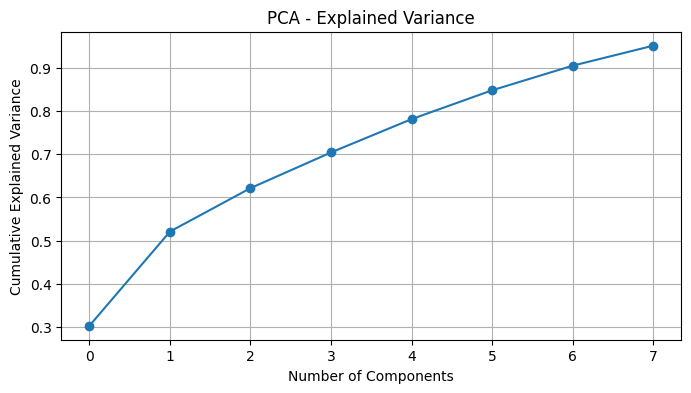

In [141]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

wma_cols = [col for col in X.columns if '_wma' in col]
for col in wma_cols:
    X[col] = X.groupby('player_id')[col].fillna(method='ffill').fillna(method='bfill')
X_numeric = X.drop(['start_date', 'player_id','gender'], axis=1)
X_numeric = X_numeric.dropna()
X_numeric_scaled = StandardScaler().fit_transform(X_numeric)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_numeric_scaled)
print("Total number of components:", X.columns.shape)
print("Number of components selected:", pca.n_components_)

# Plot explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()

In [143]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

# Model
model = XGBRegressor(n_estimators=100, random_state=42, colsample_bytree=0.8, learning_rate= 0.1,
                     max_depth= 8, reg_alpha= 0.1, reg_lambda= 1.0, subsample =1.0)

# Recursive Feature Elimination

# Drop 'start_date' before fitting RFE
X_rfe = X.drop(['start_date','player_id','gender'], axis=1)
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_rfe, y)

# Now, use the selected features for the model training and prediction
# Ensure X_train and X_test also only contain the selected features
X_train_selected = X_train[X_rfe.columns[rfe.support_]]
X_test_selected = X_test[X_rfe.columns[rfe.support_]]


model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

importances = model.feature_importances_
feature_names = X_train_selected.columns

print("-- XGBoost with RFE Scores --")
print()
print(f"Test R²: {r2:.4f}")
print(f"Test MSE: {mse:.4f}")

print('- Feature Wise Importance -')
for feature, importance in zip(feature_names, importances):
  print(f"{feature}: {importance:.4f}")

# Show top features
# Use the columns from X_rfe for indexing
selected_features = X_rfe.columns[rfe.support_]
print("\n\nTop 10 selected features by RFE:")
print(selected_features)

-- XGBoost with RFE Scores --

Test R²: 0.5118
Test MSE: 589.9860
- Feature Wise Importance -
balls_bowled: 0.2151
dot_balls_as_batsman_percentage: 0.0677
batting_aggression: 0.2211
boundaries_wma: 0.0464
fielding_wma: 0.0466
runs_conceded_wma: 0.0416
wickets_taken_wma: 0.1794
rolling_fantasy_batting: 0.0435
rolling_fantasy_bowling: 0.0991
rolling_fantasy_total: 0.0395


Top 10 selected features by RFE:
Index(['balls_bowled', 'dot_balls_as_batsman_percentage', 'batting_aggression',
       'boundaries_wma', 'fielding_wma', 'runs_conceded_wma',
       'wickets_taken_wma', 'rolling_fantasy_batting',
       'rolling_fantasy_bowling', 'rolling_fantasy_total'],
      dtype='object')


In [ ]:
!pip install shap

100%|===================| 31351/31442 [05:17<00:00]       

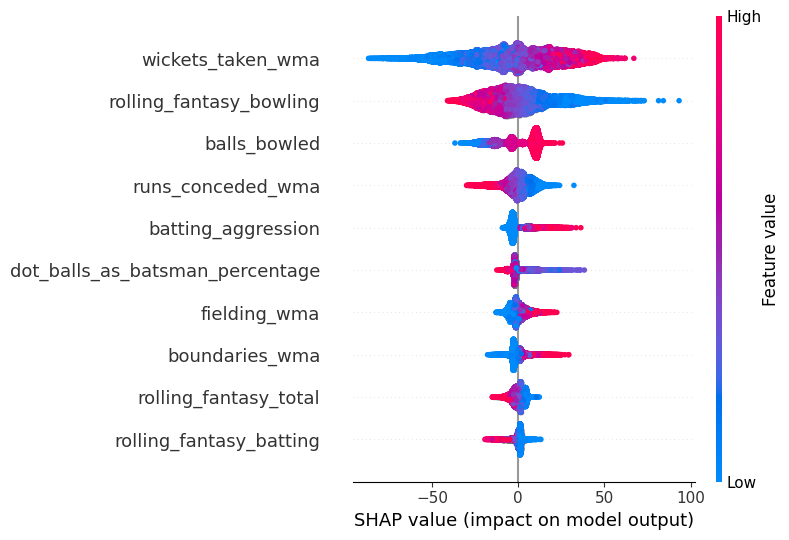

In [144]:
import shap
explainer = shap.Explainer(model, X_test_selected)
shap_values = explainer(X_test_selected)
shap.summary_plot(shap_values, X_test_selected)


## Going to stick with Batsmen - T20 **

In [64]:
df_bat = df_wma[df_wma['player_role'] == 'Batsman']
X = df_bat.drop(columns=['start_date', 'fantasy_score_batting','match_type',
                         'fantasy_score_bowling','fantasy_score_total','match_id','player_role','balls_faced','dot_balls_as_batsman'])
y = df_bat.fantasy_score_total

KeyError: "['economy'] not found in axis"